In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_theme(style="whitegrid")

def load_and_check_data(filepath, encoding='utf-8'):
    """
    Reads CSV and performs basic validation
    """
    try:        
        df = pd.read_csv(filepath)
        
        # Check if essential columns are missing
        required_columns = ['order_date', 'delivery_date', 'sales', 'profit', 'region', 'order_id']
        if not set(required_columns).issubset(df.columns):
            print(f"Error: Missing columns. Expected {required_columns}")
            return None
            
        print(f"Data loaded successfully: {len(df)} rows.")
        return df      
               
    except FileNotFoundError:
        print(f"Error! File '{filepath}' not found.")
        return None



In [42]:
def clean_data(df):
    """
    Handles data types and filters invalid rows
    """
    # Create a copy to avoid SettingWithCopyWarning
    df = df.copy()
    
    # 1. Convert to datetime
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
    df['delivery_date'] = pd.to_datetime(df['delivery_date'], errors='coerce')
    
    # 2. Filter out missing data
    df = df.dropna(subset=['order_date', 'delivery_date', 'sales'])
    
    # 3. Filter out returns (negative sales) to calculate proper margins
    df = df[df['sales'] > 0]
    
    # 4. Clean Customer ID (Splits by '_' and takes the last part)
    df['customer_id'] = df['customer_id'].astype(str).str.split('_').str[-1]

    # 5. Translate Regions from Chinese to English
    region_map = {
        '华北': 'North China',
        '华东': 'East China',
        '华南': 'South China',
        '华中': 'Central China',
        '东北': 'Northeast',
        '西南': 'Southwest',
        '西北': 'Northwest'
    }
    df['region'] = df['region'].map(region_map).fillna('Other')

    return df

In [43]:

def feature_engineering(df):
    """
    Creates new metrics for analysis
    """
    df = df.copy()
    
    # Calculate shipping time in days
    df['shipping_delay'] = (df['delivery_date'] - df['order_date']).dt.days
    
    # Calculate Profit Margin
    df['profit_margin'] = df['profit'] / df['sales']
    
    return df

In [44]:
def get_regional_performance(df):
    """
    Aggregates data by region to find insights.
    """
    # Group by region
    stats = df.groupby('region').agg(
        total_sales=('sales', 'sum'),
        total_profit=('profit', 'sum'),
        avg_delay=('shipping_delay', 'mean'),
        num_orders=('order_id', 'count')
    ).reset_index()
    
    # Calculate Weighted Profit Margin
    stats['weighted_margin'] = round(stats['total_profit'] / stats['total_sales'], 4)
    
    # Sort by sales to make the chart look better
    return stats.sort_values('total_sales', ascending=False)

In [45]:
def plot_dual_axis(stats_df):
    """
    Visualizes Sales and Margin on the same chart.
    """
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar Chart for Sales
    sns.barplot(data=stats_df, x='region', y='total_sales', 
                color='steelblue', alpha=0.6, ax=ax1, label='Sales Volume')
    ax1.set_ylabel('Total Sales ($)', fontweight='bold')
    ax1.set_xlabel('Region', fontweight='bold')

    ax1.grid(visible=True, axis='y', alpha=0.3)

    # Line Chart for Margin
    ax2 = ax1.twinx()
    sns.lineplot(data=stats_df, x='region', y='weighted_margin', 
                 color='red', marker='o', linewidth=2, ax=ax2, label='Profit Margin')
    ax2.set_ylabel('Profit Margin', fontweight='bold')
    
    #Turn off the grid on the right axis, since it clutters the view
    ax2.grid(visible=False)

    import matplotlib.ticker as ticker
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    ax2.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=1))

    # Combine legends manually 
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', ncol=2)
    if ax2.get_legend(): # Remove duplicate legend
        ax2.get_legend().remove()

    plt.title('Regional Performance: Sales vs. Profit Margin', fontsize=14, pad=10, fontweight='bold', loc='center')
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('regional_analysis_plot.png', dpi=300)

Data loaded successfully: 2770 rows.

--- Regional Summary ---
          region   total_sales  avg_delay  weighted_margin
2    North China  3.383488e+06   7.544568           0.2771
0  Central China  2.173190e+06   9.878136           0.2721
4    South China  1.213790e+06   5.390909           0.2497
3      Northeast  3.587315e+05   6.422977           0.2678
1     East China  3.285398e+05   2.559441           0.2728
5      Southwest  2.467179e+05   9.514056           0.2497


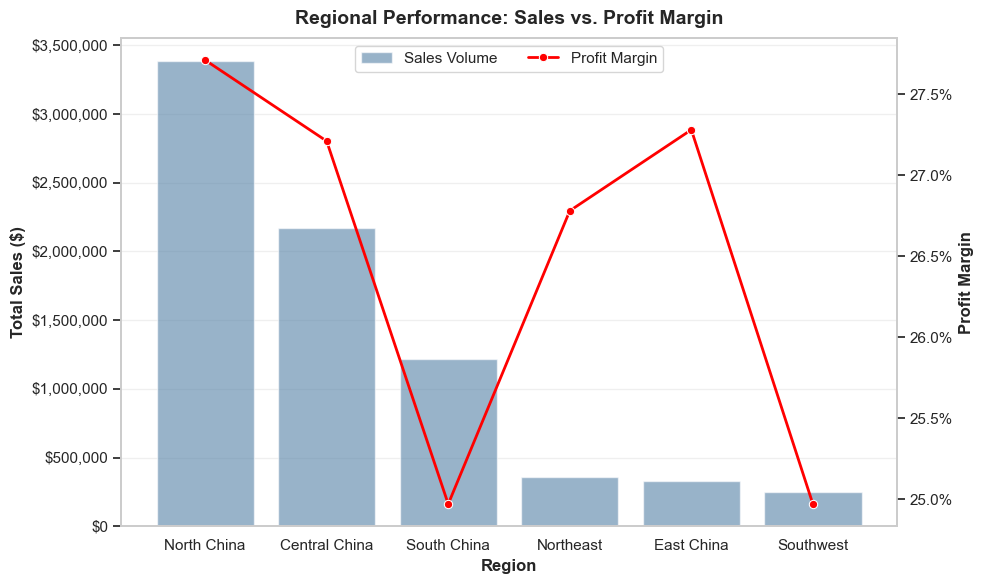

In [46]:
# --- Main Analysis Flow ---
if __name__ == "__main__":
    # Use forward slashes to avoid escape sequences like '\t' in '\transaction'
    file_path = '../data/transaction_data.csv'
    
    # 1. Ingest
    raw_df = load_and_check_data(file_path)
    
    if raw_df is not None:
        # 2. Wrangle
        clean_df = clean_data(raw_df)
        final_df = feature_engineering(clean_df)
        
        # 3. Analyze
        region_stats = get_regional_performance(final_df)
        
        # 4. Output Results
        print("\n--- Regional Summary ---")
        # Format columns for better readability
        print(region_stats[['region', 'total_sales', 'avg_delay', 'weighted_margin']])
        
        # 5. Visualize
        plot_dual_axis(region_stats)